In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pickle
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = ('/content/gdrive/My Drive/ADL_files/train_10.pkl')
with open(path, 'rb') as f:
    patch_level4, patch_level3, patch_level2, y = pickle.load(f)

In [ ]:
print(len(y))

12503


In [ ]:
X_4 = np.array(patch_level4)/255
X_3 = np.array(patch_level3)/255
X_2 = np.array(patch_level2)/255
label = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import cv2

In [ ]:
patch_size = 75

In [ ]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  ], name = "Data_Augmentation")

# Inception Model

In [ ]:
base_model_1 = InceptionV3(input_shape=[patch_size, patch_size, 3], include_top=False)
base_model_1.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model1 = Sequential([ data_augmentation, base_model_1, global_average_layer, dense_layer_1])

depth4_input = Input(shape=(patch_size, patch_size, 3))
depth4_image = model1(depth4_input)

base_model_2 = InceptionV3(input_shape=[patch_size, patch_size, 3], include_top=False)
base_model_2.trainable = False 
dense_layer_1 = Dense(32, activation='relu')
model2 = Sequential([data_augmentation, base_model_2, global_average_layer, dense_layer_1])

depth3_input = Input(shape=(patch_size, patch_size, 3))
depth3_image = model2(depth3_input)

base_model_3 = tf.keras.applications.InceptionV3(input_shape=[patch_size, patch_size, 3], include_top=False)
base_model_3.trainable = False 
dense_layer_1 = Dense(32, activation='relu')
model3 = Sequential([data_augmentation, base_model_3, global_average_layer, dense_layer_1])

depth2_input = Input(shape=(patch_size, patch_size, 3))
depth2_image = model3(depth2_input)

merged = keras.layers.concatenate([depth4_image, depth3_image, depth2_image])
merged_dense_1 = Dense(32, activation='relu')(merged)
merged_dense_2 = Dense(16, activation='relu')(merged_dense_1)
output = Dense(1, activation='sigmoid')(merged_dense_2)

final_model = Model(inputs=[depth4_input, depth3_input, depth2_input], outputs=output)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           21868352    ['input_2[0][0]']                
                                                                                              

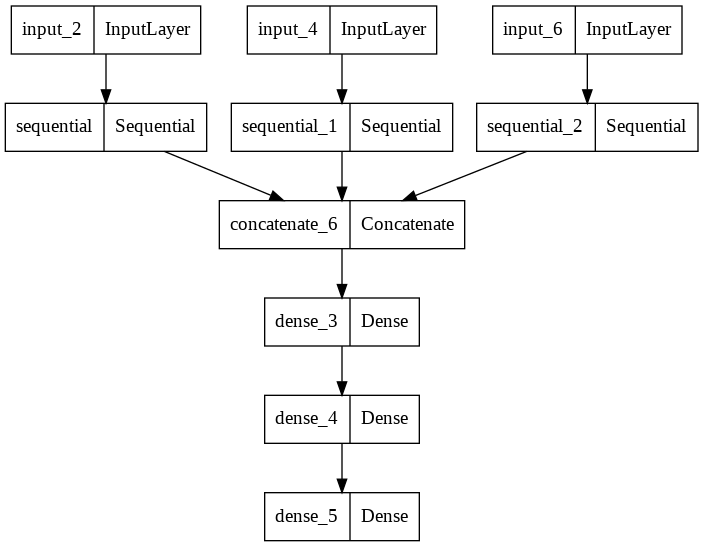

In [ ]:
plot_model(final_model)

In [ ]:
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = final_model.fit(x=[X_5, X_3, X_2], y=label, validation_split=0.3, epochs = 15)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


274/274 [==============================] - 72s 178ms/step - loss: 0.1258 - accuracy: 0.9649 - val_loss: 0.1166 - val_accuracy: 0.9725
Epoch 2/15
274/274 [==============================] - 41s 150ms/step - loss: 0.0869 - accuracy: 0.9750 - val_loss: 0.1243 - val_accuracy: 0.9733
Epoch 3/15
274/274 [==============================] - 45s 163ms/step - loss: 0.0854 - accuracy: 0.9763 - val_loss: 0.1171 - val_accuracy: 0.9736
Epoch 4/15
274/274 [==============================] - 40s 147ms/step - loss: 0.0752 - accuracy: 0.9781 - val_loss: 0.1101 - val_accuracy: 0.9723
Epoch 5/15
274/274 [==============================] - 41s 150ms/step - loss: 0.0742 - accuracy: 0.9781 - val_loss: 0.1260 - val_accuracy: 0.9733
Epoch 6/15
274/274 [==============================] - 40s 146ms/step - loss: 0.0706 - accuracy: 0.9803 - val_loss: 0.1218 - val_accuracy: 0.9699
Epoch 7/15
274/274 [==============================] - 44s 162ms/step - loss: 0.0688 - accuracy: 0.9818 - val_loss: 0.1229 - val_accuracy: 0.9

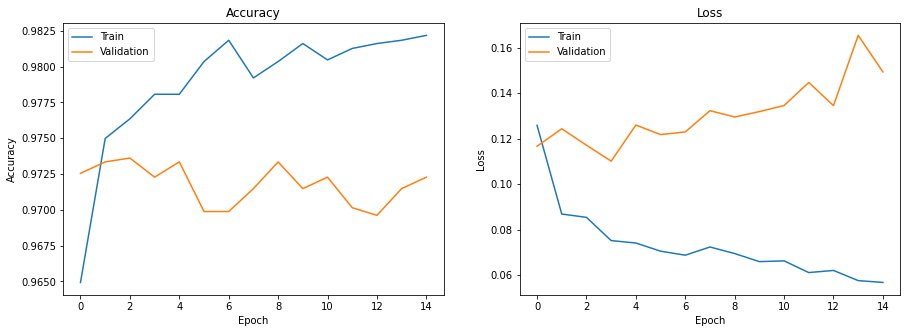

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
path = '/content/gdrive/My Drive/ADL_files/'
model = models.load_model(os.path.join(path, 'model_inception.h5'))

# VGG-16

In [ ]:
base_1 = keras.applications.VGG16(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_1.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model1 = Sequential([data_augmentation, base_1,global_average_layer,dense_layer_1])

depth4_input = Input(shape=(patch_size, patch_size, 3))
depth4_image = model1(depth4_input)

base_2 = keras.applications.VGG16(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_2.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model2 = Sequential([ data_augmentation, base_2,global_average_layer, dense_layer_1])

depth3_input = Input(shape=(patch_size, patch_size, 3))
depth3_image = model2(depth3_input)

base_3 = keras.applications.VGG16(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_3.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model3 = Sequential([data_augmentation, base_3, global_average_layer, dense_layer_1])

depth2_input = Input(shape=(patch_size, patch_size, 3))
depth2_image = model3(depth2_input)

merged = keras.layers.concatenate([depth4_image, depth3_image, depth2_image])
 
merged_dense_1 = Dense(32, activation='relu')(merged)
merged_dense_2 = Dense(16, activation='relu')(merged_dense_1)
output = Dense(1, activation='sigmoid')(merged_dense_2)

final_model = Model(inputs=[depth4_input, depth3_input, depth2_input], outputs=output)

In [ ]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 sequential_8 (Sequential)      (None, 32)           14731104    ['input_19[0][0]']               
                                                                                            

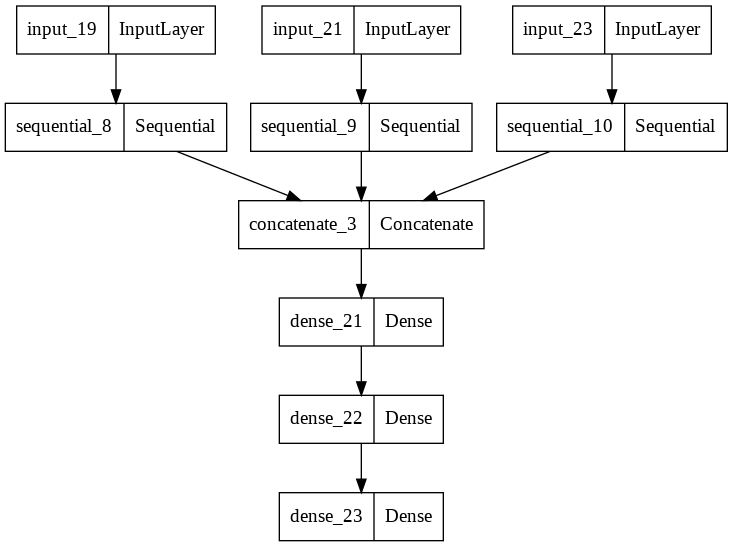

In [ ]:
plot_model(final_model)

In [ ]:
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = final_model.fit(x=[X_4, X_3, X_2], y=label, validation_split=0.3, epochs = 15)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


274/274 [==============================] - 63s 193ms/step - loss: 0.1415 - accuracy: 0.9599 - val_loss: 0.1005 - val_accuracy: 0.9723
Epoch 2/15
274/274 [==============================] - 49s 177ms/step - loss: 0.1030 - accuracy: 0.9685 - val_loss: 0.1017 - val_accuracy: 0.9736
Epoch 3/15
274/274 [==============================] - 49s 177ms/step - loss: 0.0972 - accuracy: 0.9729 - val_loss: 0.1007 - val_accuracy: 0.9747
Epoch 4/15
274/274 [==============================] - 46s 168ms/step - loss: 0.0892 - accuracy: 0.9754 - val_loss: 0.1007 - val_accuracy: 0.9752
Epoch 5/15
274/274 [==============================] - 47s 172ms/step - loss: 0.0858 - accuracy: 0.9758 - val_loss: 0.1024 - val_accuracy: 0.9747
Epoch 6/15
274/274 [==============================] - 51s 187ms/step - loss: 0.0855 - accuracy: 0.9773 - val_loss: 0.1018 - val_accuracy: 0.9741
Epoch 7/15
274/274 [==============================] - 50s 183ms/step - loss: 0.0832 - accuracy: 0.9760 - val_loss: 0.0990 - val_accuracy: 0.9

In [ ]:
path = '/content/gdrive/My Drive/ADL_files/'
final_model.save(os.path.join(path, 'model_VGG16.h5'))

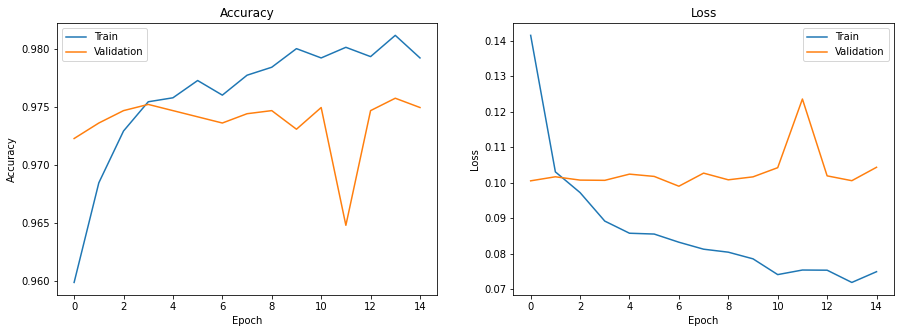

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Resnet 

In [ ]:
base_1 = keras.applications.resnet50.ResNet50(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_1.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model1 = Sequential([data_augmentation, base_1,global_average_layer,dense_layer_1], name = "sq_4")

depth4_input = Input(shape=(patch_size, patch_size, 3), name = "x_4")
depth4_image = model1(depth4_input)

base_2 = keras.applications.resnet50.ResNet50(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_2.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model2 = Sequential([ data_augmentation, base_2,global_average_layer, dense_layer_1], name = "sq_3")

depth3_input = Input(shape=(patch_size, patch_size, 3), name = "x_3")
depth3_image = model2(depth3_input)

base_3 = keras.applications.resnet50.ResNet50(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_3.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model3 = Sequential([data_augmentation, base_3, global_average_layer, dense_layer_1], name = "Sequential_Level_2")

depth2_input = Input(shape=(patch_size, patch_size, 3), name = "x_2")
depth2_image = model3(depth2_input)

merged = keras.layers.concatenate([depth4_image, depth3_image, depth2_image])
 
merged_dense_1 = Dense(32, activation='relu')(merged)
merged_dense_2 = Dense(16, activation='relu')(merged_dense_1)
output = Dense(1, activation='sigmoid')(merged_dense_2)

final_model = Model(inputs=[depth4_input, depth3_input, depth2_input], outputs=output)

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_4 (InputLayer)               [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 x_3 (InputLayer)               [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 x_2 (InputLayer)               [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 sq_4 (Sequential)              (None, 32)           23653280    ['x_4[0][0]']                    
                                                                                              

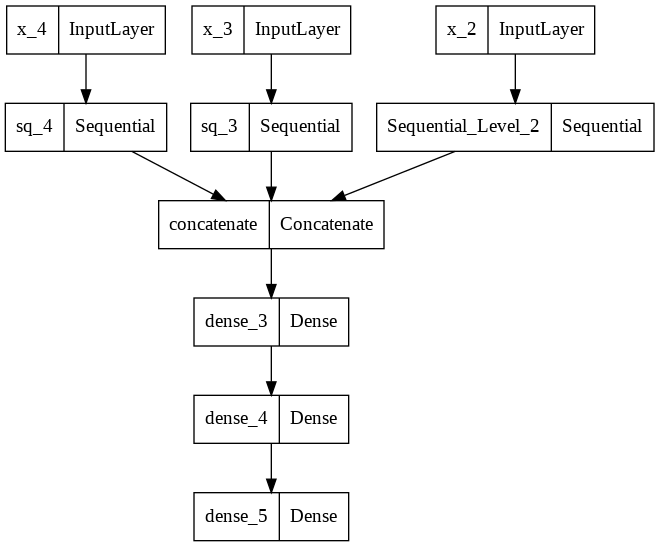

In [ ]:
plot_model(final_model)

In [ ]:
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = final_model.fit(x=[X_5, X_3, X_2], y=label, validation_split=0.3, epochs = 15)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


274/274 [==============================] - 71s 194ms/step - loss: 0.1673 - accuracy: 0.9609 - val_loss: 0.1241 - val_accuracy: 0.9723
Epoch 2/15
274/274 [==============================] - 45s 165ms/step - loss: 0.1571 - accuracy: 0.9609 - val_loss: 0.1238 - val_accuracy: 0.9723
Epoch 3/15
274/274 [==============================] - 45s 165ms/step - loss: 0.1475 - accuracy: 0.9609 - val_loss: 0.1212 - val_accuracy: 0.9723
Epoch 4/15
274/274 [==============================] - 44s 161ms/step - loss: 0.1357 - accuracy: 0.9609 - val_loss: 0.1368 - val_accuracy: 0.9723
Epoch 5/15
274/274 [==============================] - 44s 161ms/step - loss: 0.1301 - accuracy: 0.9609 - val_loss: 0.1250 - val_accuracy: 0.9723
Epoch 6/15
274/274 [==============================] - 47s 171ms/step - loss: 0.1269 - accuracy: 0.9612 - val_loss: 0.1266 - val_accuracy: 0.9723
Epoch 7/15
274/274 [==============================] - 48s 175ms/step - loss: 0.1266 - accuracy: 0.9610 - val_loss: 0.1276 - val_accuracy: 0.9

In [ ]:
path = '/content/gdrive/My Drive/ADL_files/V_1'
final_model.save(os.path.join(path, 'model_Resnet50.h5'))

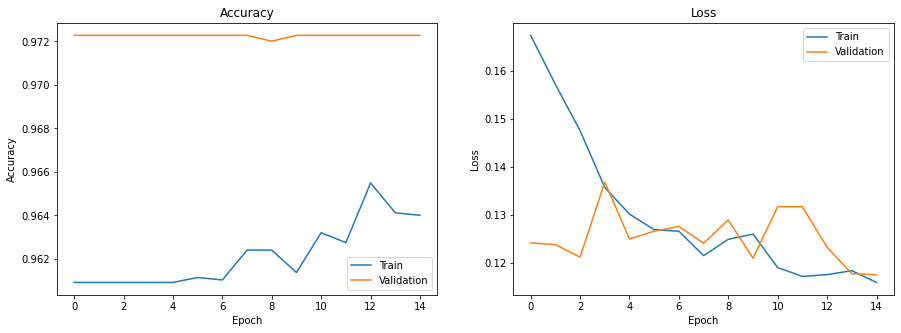

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MobileNet 

In [ ]:
base_1 = keras.applications.mobilenet.MobileNet(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_1.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model1 = Sequential([data_augmentation, base_1,global_average_layer,dense_layer_1])

depth4_input = Input(shape=(patch_size, patch_size, 3))
depth4_image = model1(depth4_input)

base_2 = keras.applications.mobilenet.MobileNet(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_2.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model2 = Sequential([ data_augmentation, base_2,global_average_layer, dense_layer_1])

depth3_input = Input(shape=(patch_size, patch_size, 3))
depth3_image = model2(depth3_input)

base_3 = keras.applications.mobilenet.MobileNet(weights = 'imagenet', input_shape=[patch_size, patch_size, 3], include_top=False)
base_3.trainable = False 

global_average_layer = GlobalAveragePooling2D()
dense_layer_1 = Dense(32, activation='relu')

model3 = Sequential([data_augmentation, base_3, global_average_layer, dense_layer_1])

depth2_input = Input(shape=(patch_size, patch_size, 3))
depth2_image = model3(depth2_input)

merged = keras.layers.concatenate([depth4_image, depth3_image, depth2_image])
 
merged_dense_1 = Dense(32, activation='relu')(merged)
merged_dense_2 = Dense(16, activation='relu')(merged_dense_1)
output = Dense(1, activation='sigmoid')(merged_dense_2)

final_model = Model(inputs=[depth4_input, depth3_input, depth2_input], outputs=output)

In [ ]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 32)           3261664     ['input_8[0][0]']                
                                                                                            

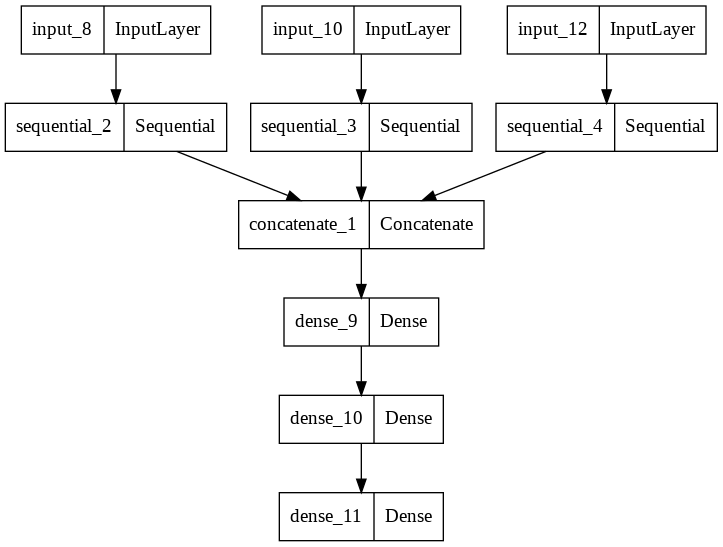

In [ ]:
plot_model(final_model)

In [ ]:
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = final_model.fit(x=[X_4, X_3, X_2], y=label, validation_split=0.3, epochs = 15)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


274/274 [==============================] - 55s 138ms/step - loss: 0.1323 - accuracy: 0.9580 - val_loss: 0.1225 - val_accuracy: 0.9725
Epoch 2/15
274/274 [==============================] - 32s 116ms/step - loss: 0.0897 - accuracy: 0.9738 - val_loss: 0.1599 - val_accuracy: 0.9725
Epoch 3/15
274/274 [==============================] - 33s 119ms/step - loss: 0.0780 - accuracy: 0.9769 - val_loss: 0.1571 - val_accuracy: 0.9725
Epoch 4/15
274/274 [==============================] - 31s 115ms/step - loss: 0.0710 - accuracy: 0.9811 - val_loss: 0.1686 - val_accuracy: 0.9736
Epoch 5/15
274/274 [==============================] - 32s 116ms/step - loss: 0.0716 - accuracy: 0.9800 - val_loss: 0.1892 - val_accuracy: 0.9725
Epoch 6/15
274/274 [==============================] - 31s 115ms/step - loss: 0.0696 - accuracy: 0.9799 - val_loss: 0.1681 - val_accuracy: 0.9736
Epoch 7/15
274/274 [==============================] - 31s 113ms/step - loss: 0.0676 - accuracy: 0.9811 - val_loss: 0.1556 - val_accuracy: 0.9

In [ ]:
path = '/content/gdrive/My Drive/ADL_files/'
final_model.save(os.path.join(path, 'model_Mobilenet.h5'))

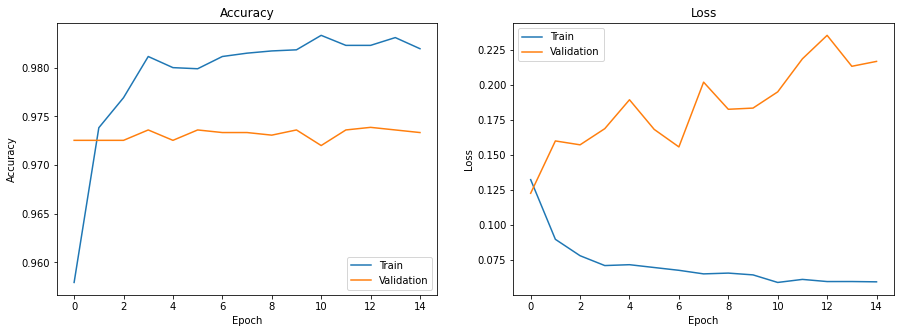

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Testing

In [ ]:
# Read a portion of a .tif file
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
path = '/content/gdrive/My Drive/ADL_Raw_Data'

slideNames = []
masksNames = [] 

for file in os.listdir(path): 
    if "tif" in file and "mask" not in file:
        maskname = file[:-4]+"_mask.tif"
        masksNames.append(maskname)
        slideNames.append(file)

slideNames.sort()
masksNames.sort()

slides = []
for file in slideNames:
    slides.append(os.path.join(path,file))  

masks = []
for file in masksNames:
    masks.append(os.path.join(path,file))


print(slides)
print(masks)
print("Total Slides Files in Directory", len(slides))
print("Total Masks Files in Directory", len(masks))

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_001.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_002.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_005.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_012.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_016.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_059.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_064.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_091.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_094.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_096.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_101.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_110.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_001_mask.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_002_mask.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_005_mask.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_012_mask.tif', '/content/gdrive/My Drive/ADL_Raw_Data/tumor_016_mask.tif', '/content/gdrive/My Drive/ADL_Raw_Data

In [ ]:
from scipy import ndimage

In [ ]:
def prediction(testFile, model):
  path = '/content/gdrive/My Drive/ADL_files'
  patch_level_4 = []
  patch_level_3 = []
  patch_level_2 = []
  y = []
  with open(os.path.join(path, testFile), 'rb') as f:
    patch_level_4, patch_level_3, patch_level_2, y = pickle.load(f)

  test_X_4 = np.array(patch_level_4)/255
  test_X_3 = np.array(patch_level_3)/255
  test_X_2 = np.array(patch_level_2)/255
  label = np.array(y)
  y_pred = model.predict(x=[test_X_4, test_X_3, test_X_2])
  return np.round(y_pred),label

In [ ]:
def getSlideMaskPred(y_pred, slide, mask,level,patchSize):
  slide_img = open_slide(slide)
  mask_img = open_slide(mask)
  width = slide_img.level_dimensions[level][0]
  height = slide_img.level_dimensions[level][1]
  slideImage = read_slide(slide_img,
                          x=0,
                          y=0,
                          level = level,
                          width = width,
                          height = height)
  
  maskImage = read_slide(mask_img,
                          x=0,
                          y=0,
                          level = level,
                          width = width,
                          height = height)
  
  stepWidth = (int)(width / patchSize)
  stepHeight = (int)(height / patchSize) 
  
  y_pred = np.reshape(y_pred, (stepWidth,stepHeight)).T
  predictedMask = ndimage.zoom(y_pred, patchSize, order=0)
  return predictedMask,maskImage,slideImage

# Prediction for Inception Model 

## Test Slide - Tumor_101.tif

In [ ]:
path = '/content/gdrive/MyDrive/ADL_files/'
model = models.load_model(os.path.join(path, 'model_inception.h5'))

In [ ]:
testFile_1 = 'test_1.pkl'
y_pred_1,y_true_1 = prediction(testFile_1,model)
print(classification_report(y_true_1, y_pred_1))

214/214 [==============================] - 23s 48ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6669
           1       0.90      0.35      0.51       175

    accuracy                           0.98      6844
   macro avg       0.94      0.68      0.75      6844
weighted avg       0.98      0.98      0.98      6844



In [ ]:
slide = slides[10:11]
mask = masks[10:11]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_1,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101_mask.tif']


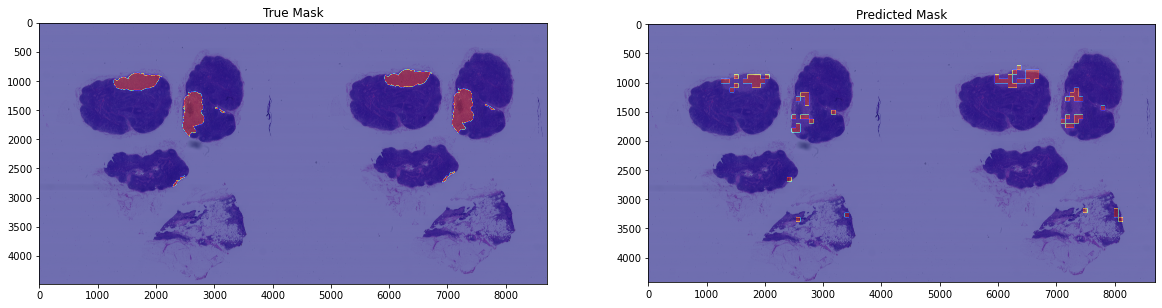

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)

## Test Slide - Tumor_110.tif

In [ ]:
testFile_2 = 'test_2.pkl'
y_pred_2,y_true_2 = prediction(testFile_2,model)
print(classification_report(y_true_2, y_pred_2))

144/144 [==============================] - 7s 51ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3752
           1       1.00      0.42      0.59       850

    accuracy                           0.89      4602
   macro avg       0.94      0.71      0.76      4602
weighted avg       0.91      0.89      0.87      4602



In [ ]:
slide = slides[11:12]
mask = masks[11:12]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_2,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110_mask.tif']


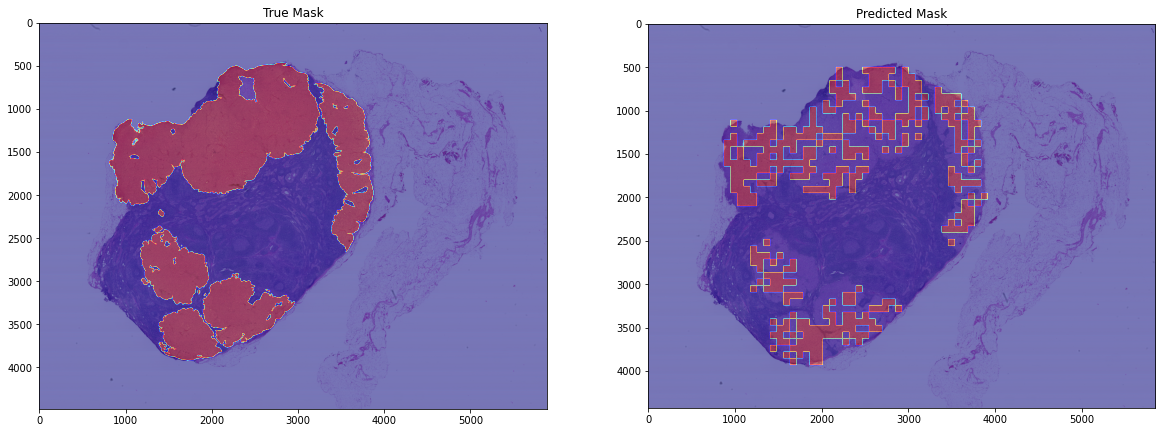

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)

# Prediction for VGG16 Model 

## Test Slide - Tumor_101.tif

In [ ]:
path = '/content/gdrive/MyDrive/ADL_files/'
model = models.load_model(os.path.join(path, 'model_VGG16.h5'))

In [ ]:
testFile_1 = 'test_1.pkl'
y_pred_1,y_true_1 = prediction(testFile_1,model)
print(classification_report(y_true_1, y_pred_1))

214/214 [==============================] - 19s 81ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6669
           1       0.95      0.57      0.71       175

    accuracy                           0.99      6844
   macro avg       0.97      0.78      0.85      6844
weighted avg       0.99      0.99      0.99      6844



In [ ]:
slide = slides[10:11]
mask = masks[10:11]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_1,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101_mask.tif']


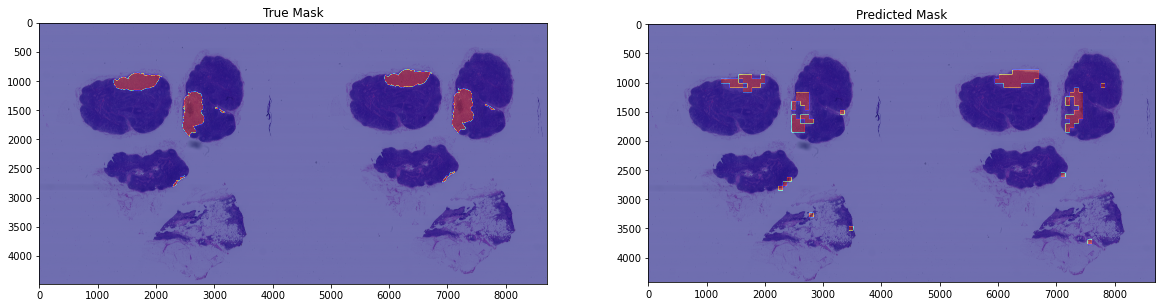

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)

## Test Slide - Tumor_110.tif

In [ ]:
testFile_2 = 'test_2.pkl'
y_pred_2,y_true_2 = prediction(testFile_2,model)
print(classification_report(y_true_2, y_pred_2))

144/144 [==============================] - 12s 83ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3752
           1       0.99      0.67      0.80       850

    accuracy                           0.94      4602
   macro avg       0.96      0.83      0.88      4602
weighted avg       0.94      0.94      0.93      4602



In [ ]:
slide = slides[11:12]
mask = masks[11:12]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_2,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110_mask.tif']


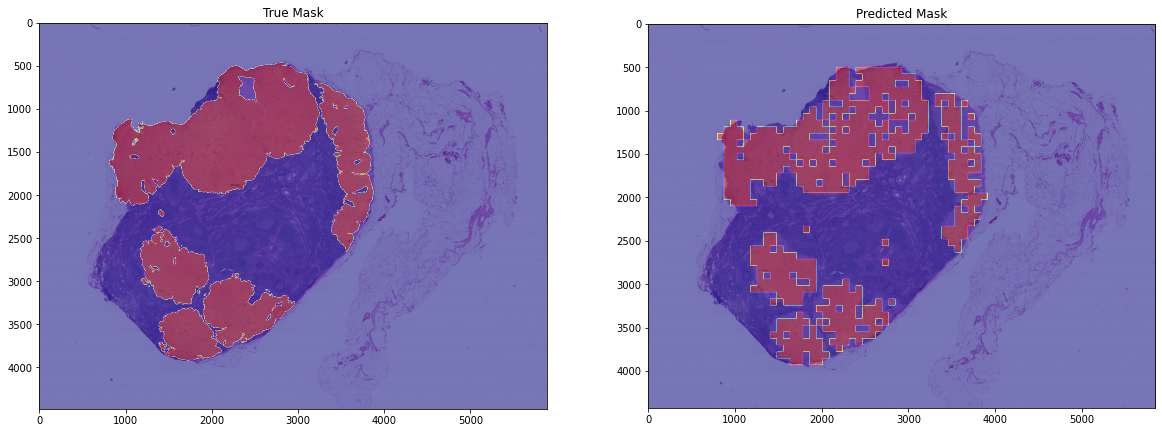

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)

# Prediction for Resnet50 Model 

## Test Slide - Tumor_101.tif

In [ ]:
path = '/content/gdrive/MyDrive/ADL_files/V_1/'
model = models.load_model(os.path.join(path, 'model_Resnet50.h5'))

In [ ]:
testFile_1 = 'test_1.pkl'
y_pred_1,y_true_1 = prediction(testFile_1,model)
print(classification_report(y_true_1, y_pred_1))

214/214 [==============================] - 20s 64ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6669
           1       1.00      0.05      0.10       175

    accuracy                           0.98      6844
   macro avg       0.99      0.53      0.54      6844
weighted avg       0.98      0.98      0.96      6844



In [ ]:
slide = slides[10:11]
mask = masks[10:11]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_1,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101_mask.tif']


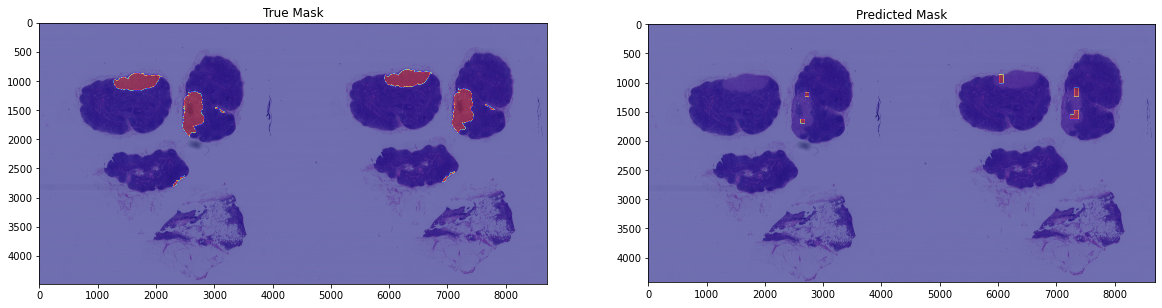

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)

## Test Slide - Tumor_110.tif

In [ ]:
testFile_2 = 'test_2.pkl'
y_pred_2,y_true_2 = prediction(testFile_2,model)
print(classification_report(y_true_2, y_pred_2))

144/144 [==============================] - 10s 70ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      3752
           1       1.00      0.00      0.01       850

    accuracy                           0.82      4602
   macro avg       0.91      0.50      0.45      4602
weighted avg       0.85      0.82      0.73      4602



In [ ]:
slide = slides[11:12]
mask = masks[11:12]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_2,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110_mask.tif']


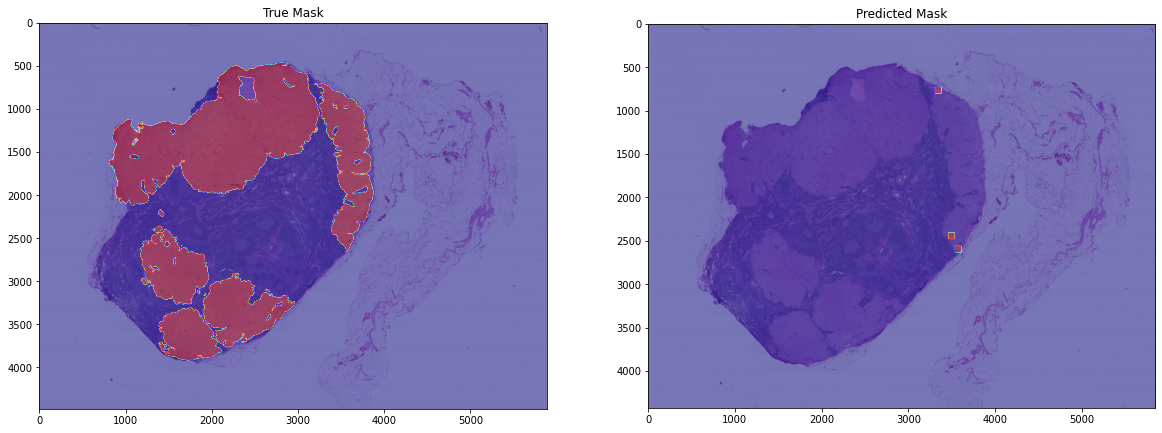

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)

# Prediction for Mobilenet Model 

## Test Slide - Tumor_101.tif

In [ ]:
path = '/content/gdrive/MyDrive/ADL_files/'
model = models.load_model(os.path.join(path, 'model_Mobilenet.h5'))

In [ ]:
testFile_1 = 'test_1.pkl'
y_pred_1,y_true_1 = prediction(testFile_1,model)
print(classification_report(y_true_1, y_pred_1))

214/214 [==============================] - 5s 17ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6669
           1       0.91      0.42      0.57       175

    accuracy                           0.98      6844
   macro avg       0.95      0.71      0.78      6844
weighted avg       0.98      0.98      0.98      6844



In [ ]:
slide = slides[10:11]
mask = masks[10:11]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_1,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_101_mask.tif']


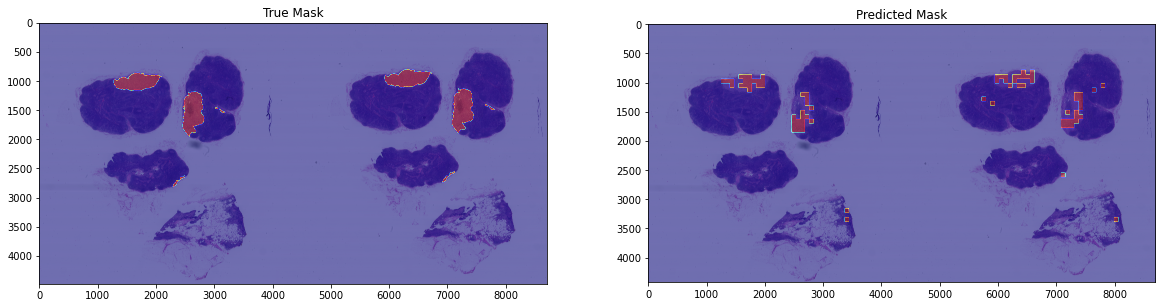

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)

## Test Slide - Tumor_110.tif

In [ ]:
testFile_2 = 'test_2.pkl'
y_pred_2,y_true_2 = prediction(testFile_2,model)
print(classification_report(y_true_2, y_pred_2))

144/144 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3752
           1       1.00      0.33      0.49       850

    accuracy                           0.88      4602
   macro avg       0.93      0.66      0.71      4602
weighted avg       0.89      0.88      0.85      4602



In [ ]:
slide = slides[11:12]
mask = masks[11:12]
print(slide)
print(mask)
level = 4
patchSize = 75
predictedMask, maskImage, slideImage = getSlideMaskPred(y_pred_2,
                                                        slide[0],
                                                        mask[0],
                                                        level,
                                                        patchSize)

['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110.tif']
['/content/gdrive/My Drive/ADL_Raw_Data/tumor_110_mask.tif']


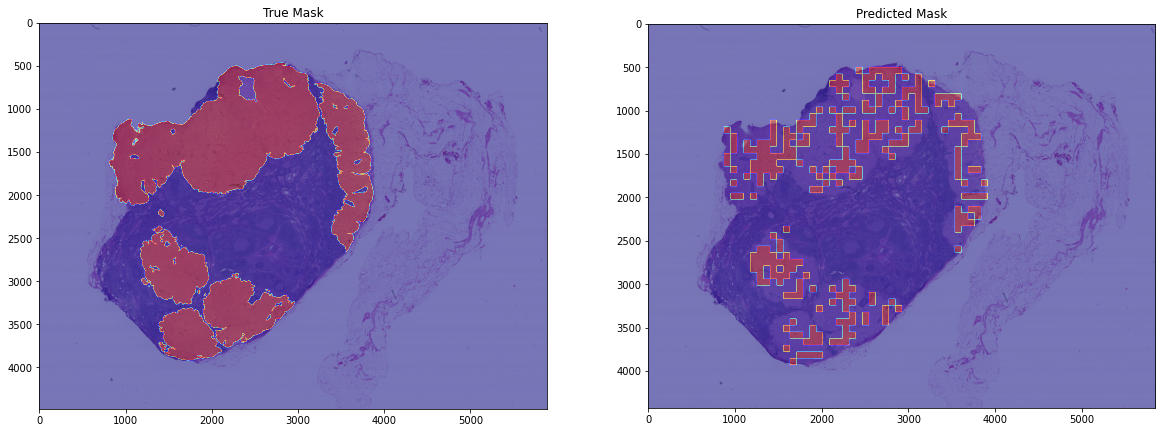

In [ ]:
fig, axis = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axis[0].set_title("True Mask")
axis[0].imshow(slideImage)
axis[0].imshow(maskImage[:,:,0], cmap='jet', alpha=0.5)

axis[1].set_title("Predicted Mask")
axis[1].imshow(slideImage)
axis[1].imshow(predictedMask, cmap='jet', alpha=0.5)